In [1]:
# %pip install matplotlib
# %pip install transformers

In [2]:
import logging
import sys
from textwrap import TextWrapper

import torch
import torch.nn.functional as F

import datasets
import huggingface_hub
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt
import torch
import transformers
from IPython.display import set_matplotlib_formats

transformers.logging.set_verbosity_error()
datasets.logging.set_verbosity_error()

/home/dangapurus/miniconda3/envs/ai-sandbox/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from datasets import load_dataset

movie_reviews = load_dataset("imdb")
# movie_reviews = load_dataset("ag_news")

In [4]:
train_ds = movie_reviews["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})

In [5]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None)}

In [6]:
import pandas as pd

movie_reviews.set_format(type="pandas")

def label_int2str(row):
    return train_ds.features["label"].int2str(row)

df = train_ds[:]
df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,I rented I AM CURIOUS-YELLOW from my video sto...,0,neg
1,"""I Am Curious: Yellow"" is a risible and preten...",0,neg
2,If only to avoid making this type of film in t...,0,neg
3,This film was probably inspired by Godard's Ma...,0,neg
4,"Oh, brother...after hearing about this ridicul...",0,neg


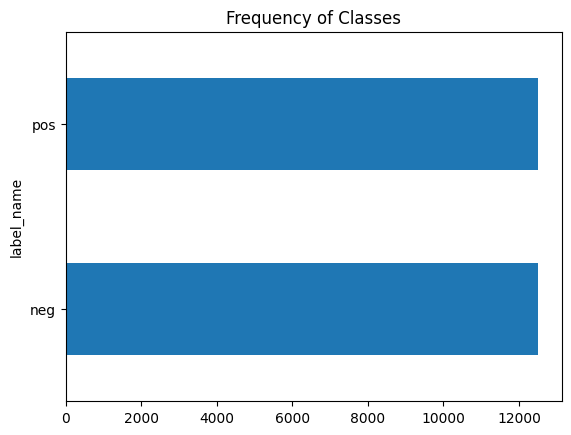

In [7]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

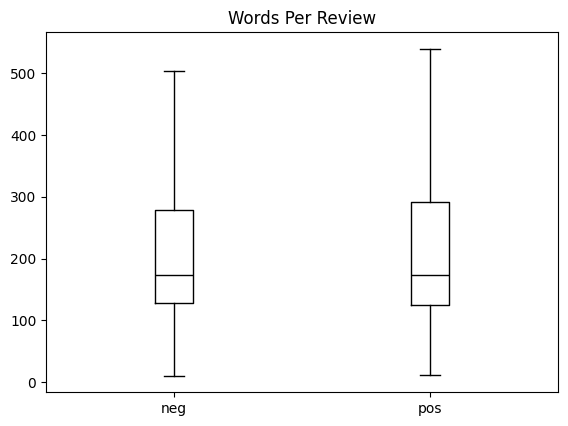

In [8]:
df["Words Per Review"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Review", by="label_name", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

Transformer models have a maximum input sequence length that is referred to as the _maximum context size_. For applications using DistilBERT, the maximum context size is 512 tokens, which amounts to a few paragraphs of text. As we'll see in the next section, a token is an atomic piece of text; for now, we'll treat a token as a single word. We can get a rough estimate of tweet lengths per emotion by looking at the distribution of words per review.

In [9]:
movie_reviews.reset_format()

In [10]:
# hide_output
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [11]:
movie_reviews["train"][0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

In [12]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

text = movie_reviews["train"][0]['text']
encoded_text = tokenizer(text)
encoded_text

tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
tokens
tokenizer.convert_tokens_to_string(tokens)


# train_ds = train_ds.map(tokenize, batched=True)

'[CLS] i rented i am curious - yellow from my video store because of all the controversy that surrounded it when it was first released in 1967. i also heard that at first it was seized by u. s. customs if it ever tried to enter this country, therefore being a fan of films considered " controversial " i really had to see this for myself. < br / > < br / > the plot is centered around a young swedish drama student named lena who wants to learn everything she can about life. in particular she wants to focus her attentions to making some sort of documentary on what the average swede thought about certain political issues such as the vietnam war and race issues in the united states. in between asking politicians and ordinary denizens of stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men. < br / > < br / > what kills me about i am curious - yellow is that 40 years ago, this was considered pornographic. really, the sex and nudity scenes 

In [13]:
emotions_encoded = movie_reviews.map(tokenize, batched=True, batch_size=None)

Map: 100%|██████████| 25000/25000 [00:03<00:00, 7864.02 examples/s]


In [14]:
# hide_output
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [15]:
print('abx')

abx


In [16]:
import multiprocessing

num_cores = multiprocessing.cpu_count()
print(f'Number of CPU cores: {num_cores}')

Number of CPU cores: 32


In [17]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True, batch_size=1)
# emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True, batch_size=16,  num_proc=4)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]/home/dangapurus/miniconda3/envs/ai-sandbox/lib/python3.12/site-packages/transformers/utils/import_utils.py:653: FutureWarning: `is_compiling` is deprecated. Use `torch.compiler.is_compiling()` instead.
  return dynamo.is_compiling()
Map: 100%|██████████| 50000/50000 [09:12<00:00, 90.55 examples/s]


In [19]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 50000
    })
})

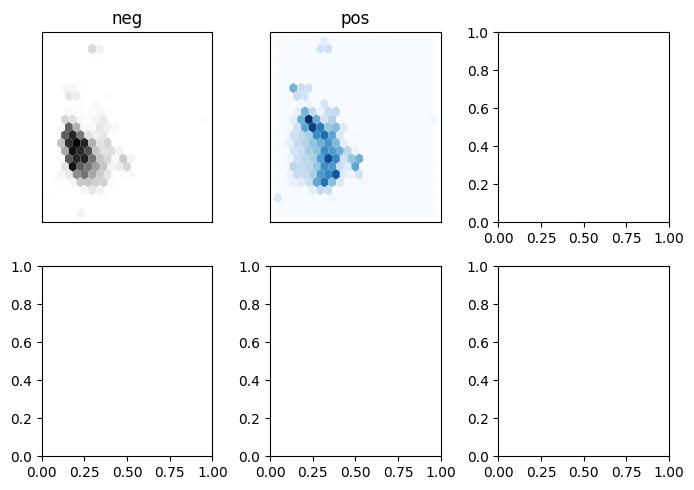

In [25]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["test"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["test"]["label"])
X_train.shape, X_valid.shape

# from umap import UMAP
from umap import umap_ as UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP.UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()


fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = movie_reviews["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

In [26]:
#hide_output
# We increase `max_iter` to guarantee convergence 
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [27]:
lr_clf.score(X_valid, y_valid)

0.8758

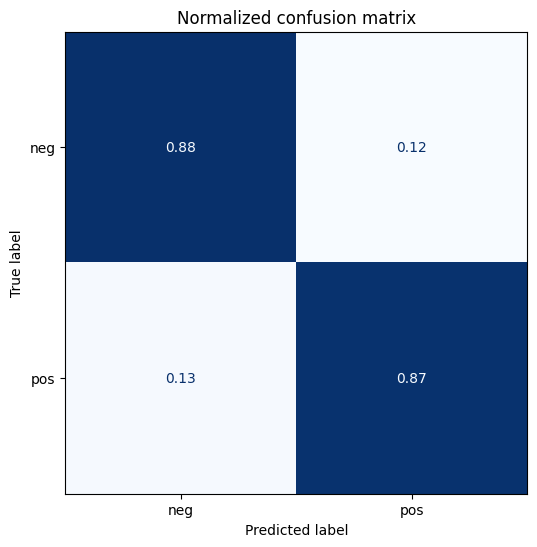

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)